In [1]:
%%bash
echo $PYTHONPATH

/Users/wamess/PycharmProjects/windTurbineExp


In [2]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

import data_load
import data_process
import model
import train_model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from sklearn import preprocessing

DATA_PATH = "../data/Turbine_Data_Penmanshiel_11_2021-01-01_-_2021-07-01_1051.csv"
LOGS_PATH = "../data/Status_Penmanshiel_11_2021-01-01_-_2021-07-01_1051.csv"

data = data_load.load_turbine_data_without_time(DATA_PATH)
logs = data_load.load_turbine_logs_with_endtime(LOGS_PATH)
labels = data_load.get_data_label(data_load.load_turbine_data(DATA_PATH), logs)
scaler = preprocessing.StandardScaler()
data_imputer = KNNImputer(n_neighbors=10)
data = data_process.impute_data(data)
data = data_process.standardize_data(data, scaler=scaler)
print(data.shape)
data = np.array(data, dtype='float32')

(26064, 290)


In [4]:
from sklearn.model_selection import train_test_split

epochs = 3000
k = 10

i = 0
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1)
# for train, test in kf.split(data):
#     ae_model = model.AutoEncoder(input_size=np.size(data, axis=1)).to(device)
#     loss = nn.MSELoss()
#     # optimizer = torch.optim.SGD(ae_model.parameters(), lr=0.001)
#     optimizer = torch.optim.Adam(ae_model.parameters(), lr=0.0015)
#     train_labels = labels[train]
#     test_labels = labels[test]
#     X_train, X_test = data[train][train_labels==0], data[test]
#     for epoch in range(epochs):
#         print(f"\n=====epoch {epoch}/{epochs}=====")
#         train_model.train(data_x=X_train, data_y=X_train, model=ae_model, loss_fn=loss, optimizer=optimizer,
#                           batch_size=30000)
#
#     res = train_model.autoencoder_test(X_test, X_test, ae_model, 1000)
#     i += 1
#     if i == 1:
#         break

X_train = X_train[y_train == 0]

ae_model = model.AutoEncoder(input_size=np.size(data, axis=1)).to(device)
loss = nn.MSELoss()
# optimizer = torch.optim.SGD(ae_model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(ae_model.parameters(), lr=0.0015)

for epoch in range(epochs):
    print(f"\n=====epoch {epoch}/{epochs}=====")
    train_model.train(data_x=X_train, data_y=X_train, model=ae_model, loss_fn=loss, optimizer=optimizer,
                      batch_size=30000)

res = train_model.autoencoder_test(X_test, X_test, ae_model, 1000)


=====epoch 0/3000=====
loss: 0.797738  [21847/21847]

=====epoch 1/3000=====
loss: 0.796441  [21847/21847]

=====epoch 2/3000=====
loss: 0.795260  [21847/21847]

=====epoch 3/3000=====
loss: 0.793839  [21847/21847]

=====epoch 4/3000=====
loss: 0.792156  [21847/21847]

=====epoch 5/3000=====
loss: 0.790041  [21847/21847]

=====epoch 6/3000=====
loss: 0.787142  [21847/21847]

=====epoch 7/3000=====
loss: 0.783015  [21847/21847]

=====epoch 8/3000=====
loss: 0.777249  [21847/21847]

=====epoch 9/3000=====
loss: 0.769138  [21847/21847]

=====epoch 10/3000=====
loss: 0.757346  [21847/21847]

=====epoch 11/3000=====
loss: 0.740696  [21847/21847]

=====epoch 12/3000=====
loss: 0.718024  [21847/21847]

=====epoch 13/3000=====
loss: 0.688258  [21847/21847]

=====epoch 14/3000=====
loss: 0.651096  [21847/21847]

=====epoch 15/3000=====
loss: 0.609310  [21847/21847]

=====epoch 16/3000=====
loss: 0.572469  [21847/21847]

=====epoch 17/3000=====
loss: 0.544533  [21847/21847]

=====epoch 18/3000=

0.9701557726779267


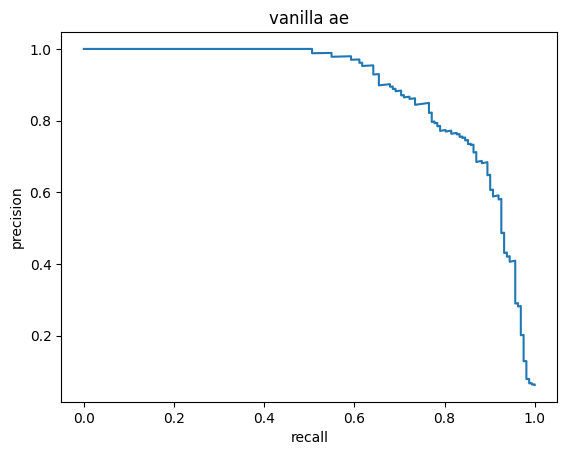

In [5]:
import sklearn.metrics as metrics

res_sorted = np.sort(res)
res_cdf = 1. * np.arange(len(res)) / (len(res) - 1)
point_color = ["red" if label == 1 else "blue" for label in y_test]
point_size = [0.1 if label == 0 else 10 for label in y_test]
# plt.hist(res, bins=200)
# plt.scatter(res, range(res.size), s=point_size, c=point_color)

fpr, tpr, _ = metrics.roc_curve(y_test, res)

precision, recall, threshold = metrics.precision_recall_curve(y_test, res)

# precision = precision[0:-3]
#
# recall = recall[0:-3]

plt.plot(recall, precision)

# print(precision, recall)

print(metrics.auc(fpr, tpr))
# print(metrics.auc(precision, recall))

# print(metrics.f1_score(test_labels, res))

# plt.scatter(res_sorted, range(res.size), s=point_size, c=point_color)
# plt.xlim(0, 150)
plt.ylabel("precision")
plt.xlabel("recall")
plt.title("vanilla ae")
plt.show()

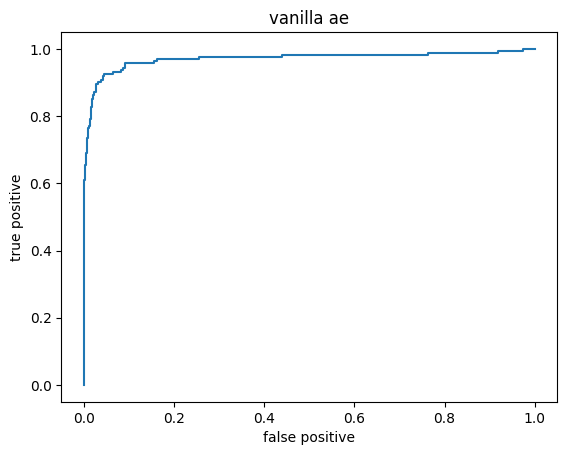

In [6]:
plt.plot(fpr, tpr)
plt.xlabel("false positive")
plt.ylabel("true positive")
plt.title("vanilla ae")
plt.show()

In [8]:
from omnixai.data.tabular import Tabular
from omnixai.preprocessing.tabular import TabularTransform
from omnixai.explainers.tabular import MACEExplainer

raw_data = data_load.load_turbine_data_without_time(DATA_PATH)
raw_data['label'] = labels
feature_names = raw_data.columns.tolist()

combined_train_data = raw_data.to_numpy()

tabular_data = Tabular(
    combined_train_data,
    feature_columns=feature_names,
    target_column='label'

)

def predict_function(x):
    x = scaler.transform(x)
    print(x)
    distance = train_model.autoencoder_test(x, x, ae_model, len(x))
    res = 1 / (1 + np.exp(-(distance-65)))
    # return torch.tensor([[n] for n in res])
    return res

# print(tabular_data)

explainer = MACEExplainer(
    training_data=tabular_data,
    predict_function=predict_function,
    ignored_features=["Wind speed, Standard deviation (m/s)","Wind speed, Minimum (m/s)","Wind speed, Maximum (m/s)","Long Term Wind (m/s)","Wind speed Sensor 1 (m/s)","Wind speed Sensor 1, Standard deviation (m/s)","Wind speed Sensor 1, Minimum (m/s)","Wind speed Sensor 1, Maximum (m/s)","Wind speed Sensor 2 (m/s)","Wind speed Sensor 2, Standard deviation (m/s)","Wind speed Sensor 2, Minimum (m/s)","Wind speed Sensor 2, Maximum (m/s)","Density adjusted wind speed (m/s)","Wind direction (°)","Wind direction, Standard deviation (°)","Wind direction, Minimum (°)","Wind direction, Maximum (°)" ]
)

X has feature names, but StandardScaler was fitted without feature names


ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 32.

In [ ]:
test_instances = tabular_data.remove_target_column()[0:5]
explanations = explainer.explain(test_instances)
explanations.get_explanations()